# Solving MNIST with Keras

In [1]:
%matplotlib inline

from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


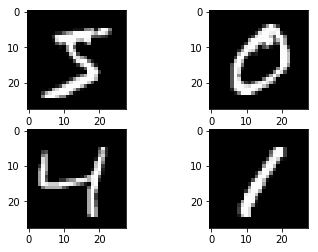

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

## Baseline Model with Multi-Layer Perceptrons
Do we really need a complex model like a convolutional neural network to get the best results with MNIST?

You can get very good results using a very simple neural network model with a single hidden layer. In this section we will create a simple multi-layer perceptron model that achieves an error rate of 1.74%. We will use this as a baseline for comparing more complex convolutional neural network models.

In [3]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

In [4]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [5]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [6]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [7]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [8]:
# define baseline model
def baseline_model():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [9]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: ", (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
5s - loss: 0.2811 - acc: 0.9199 - val_loss: 0.1403 - val_acc: 0.9578
Epoch 2/10
2s - loss: 0.1115 - acc: 0.9674 - val_loss: 0.0913 - val_acc: 0.9723
Epoch 3/10
2s - loss: 0.0712 - acc: 0.9797 - val_loss: 0.0792 - val_acc: 0.9760
Epoch 4/10
2s - loss: 0.0506 - acc: 0.9851 - val_loss: 0.0714 - val_acc: 0.9782
Epoch 5/10
2s - loss: 0.0369 - acc: 0.9897 - val_loss: 0.0670 - val_acc: 0.9791
Epoch 6/10
2s - loss: 0.0267 - acc: 0.9932 - val_loss: 0.0643 - val_acc: 0.9801
Epoch 7/10
2s - loss: 0.0204 - acc: 0.9948 - val_loss: 0.0628 - val_acc: 0.9809
Epoch 8/10
2s - loss: 0.0134 - acc: 0.9973 - val_loss: 0.0601 - val_acc: 0.9819
Epoch 9/10
3s - loss: 0.0106 - acc: 0.9979 - val_loss: 0.0567 - val_acc: 0.9821
Epoch 10/10
3s - loss: 0.0081 - acc: 0.9985 - val_loss: 0.0577 - val_acc: 0.9819
Baseline Error:  1.81


## Simple Convolutional Neural Network for MNIST

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

In [10]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [11]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].

In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [13]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

- The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
- Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
- The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
- Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
- Next a fully connected layer with 128 neurons and rectifier activation function.
Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

## Dropout Tips
- Generally use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
- Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
- Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
- Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
- Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

In [15]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
51s - loss: 0.2500 - acc: 0.9285 - val_loss: 0.0852 - val_acc: 0.9737
Epoch 2/10
50s - loss: 0.0752 - acc: 0.9781 - val_loss: 0.0625 - val_acc: 0.9795
Epoch 3/10
49s - loss: 0.0529 - acc: 0.9839 - val_loss: 0.0445 - val_acc: 0.9859
Epoch 4/10
50s - loss: 0.0415 - acc: 0.9871 - val_loss: 0.0405 - val_acc: 0.9867
Epoch 5/10
51s - loss: 0.0335 - acc: 0.9901 - val_loss: 0.0350 - val_acc: 0.9882
Epoch 6/10
50s - loss: 0.0272 - acc: 0.9919 - val_loss: 0.0360 - val_acc: 0.9885
Epoch 7/10
50s - loss: 0.0239 - acc: 0.9920 - val_loss: 0.0318 - val_acc: 0.9895
Epoch 8/10
50s - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0327 - val_acc: 0.9897
Epoch 9/10
51s - loss: 0.0180 - acc: 0.9943 - val_loss: 0.0376 - val_acc: 0.9875
Epoch 10/10
51s - loss: 0.0147 - acc: 0.9950 - val_loss: 0.0331 - val_acc: 0.9895
Baseline Error: 1.05%


Running the example, the accuracy on the training and validation test is printed each epoch and at the end of the classification error rate is printed.

Epochs may take 60 to 90 seconds to run on the CPU, or about 15 minutes in total depending on your hardware. You can see that the network achieves an error rate of 1.10, which is better than our simple multi-layer perceptron model above.

## Larger Convolutional Neural Network for MNIST

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results.

We import classes and function then load and prepare the data the same as in the previous CNN example.

In [19]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

- Convolutional layer with 30 feature maps of size 5×5.
- Pooling layer taking the max over 2*2 patches.
- Convolutional layer with 15 feature maps of size 3×3.
- Pooling layer taking the max over 2*2 patches.
- Dropout layer with a probability of 20%.
- Flatten layer.
- Fully connected layer with 128 neurons and rectifier activation.
- Fully connected layer with 50 neurons and rectifier activation.
- Output layer.

In [21]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
53s - loss: 0.4190 - acc: 0.8697 - val_loss: 0.0930 - val_acc: 0.9723
Epoch 2/10
52s - loss: 0.1073 - acc: 0.9674 - val_loss: 0.0560 - val_acc: 0.9815
Epoch 3/10
53s - loss: 0.0772 - acc: 0.9762 - val_loss: 0.0432 - val_acc: 0.9847
Epoch 4/10
54s - loss: 0.0598 - acc: 0.9816 - val_loss: 0.0353 - val_acc: 0.9890
Epoch 5/10
55s - loss: 0.0510 - acc: 0.9845 - val_loss: 0.0318 - val_acc: 0.9892
Epoch 6/10
52s - loss: 0.0441 - acc: 0.9863 - val_loss: 0.0303 - val_acc: 0.9910
Epoch 7/10
51s - loss: 0.0403 - acc: 0.9873 - val_loss: 0.0305 - val_acc: 0.9897
Epoch 8/10
51s - loss: 0.0365 - acc: 0.9886 - val_loss: 0.0267 - val_acc: 0.9908
Epoch 9/10
52s - loss: 0.0327 - acc: 0.9897 - val_loss: 0.0300 - val_acc: 0.9898
Epoch 10/10
51s - loss: 0.0308 - acc: 0.9901 - val_loss: 0.0296 - val_acc: 0.9907
Baseline Error: 0.93%


Running the example prints accuracy on the training and validation datasets each epoch and a final classification error rate.

The model takes about 100 seconds to run per epoch. This slightly larger model achieves the respectable classification error rate of 0.89%.